## Scientific Python Final Project
### Nomin Margad-Erdene

#### Introduction

As I am studying Economics and Finance, I wanted to create a small script that I can utilize later for analyzing portfolios. Also, I wanted to compare the performance of 2 different regression methods in predicting stock prices from historical data. 

First part of the script works with a portfolio of 10 stocks. I calculate the efficient allocation (relative weights) of each stock in the portfolio so that it maximizes returns or minimizes risk (standard deviation).
Second part of the script uses features (closing, opening, highest and lowest prices of the day) to predict the stock price. I use cross validation + $\href{https://en.wikipedia.org/wiki/Ordinary_least_squares}{\text{OLS}}$ and $\href{https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2}{\text{SVR}}$, and compare their out-of-sample prediction measured by $\href{https://en.wikipedia.org/wiki/Root-mean-square_deviation}{\text{RMSE}}$ (Root Mean Squared Error).

#### Data

The data is collected from $\href{https://finance.yahoo.com/}{\text{yahoo finance}}$ using pandas-datareader, therefore any existing stock ticker can be used as input for functions. The first cell of the notebook installs datareader. In case it does not work, I have backup function and .txt file containing historical data of 10 stocks, which are currently used in script. 

#### Flowchart

The flowchart below contains the logic of the code. (If you don't see it, I sent Flowchart.png with the notebook). The script is organized into functions. Names of the functions, inputs and brief descriptions are in the flowchart. In the code, each function is preceded by a markup cell that explains it's purpose. Also, there are in-line comments for more detail.

![alt text](Flowchart.png "Code Flowchart")

In [2]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from pandas_datareader import data as web
from pandas.plotting import scatter_matrix as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy.optimize import Bounds as bounds
from scipy.optimize import LinearConstraint as lc
from scipy.optimize import minimize
import matplotlib.cm as cm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
reg = linear_model.LinearRegression()
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

# Part 1: efficient allocation of a portfolio
The goal of this part is to prepare a set of functions that can give me efficient allocation based on the timeframe and portfolio of my choice. 
Efficient allocation is obtained by solving for vector of weights which correspond to the proportion of each stock in the portfolio. The vector is calculated by using Markowitz efficient portfolio theorem. 

### function: get_stocks_yahoo()

These 2 functions will query yahoo finance for any given list of tickers (stock names) and 2 dates.

#### inputs:
* stocks: list of stock tickers
* date1: beginning date of the historical data
* date2: ending date
* query: list of features (Adj Close: daily closing price, Open: opening price, High: highest price for the dat, Low: lowest price for the day)

#### outputs:
* dataframe containing closing price of stocks in columns

In [2]:
def get_stocks_yahoo(stocks, date1, date2, query):
    df = pd.DataFrame()
    for stock in stocks:
        df[stock] = web.DataReader(stock, data_source='yahoo',
                                   start=str(date1) , end=str(date2))[query]
    return df

### function: get_1stock_yahoo()

#### outputs:
* dataframe containing [Adj Close], [Open], [High], [Low] prices of one stock in columns

In [3]:
def get_1stock_yahoo(stocks, date1, date2, query):
    stock = stocks[0]
    df = pd.DataFrame()  
    for query in queries:
        df[query] = web.DataReader(stock, data_source='yahoo',
                                   start=str(date1) , end=str(date2))[query]
    return df

### functions: desc_stats()
#### inputs:
* df_close: dataframe from $\text{get_stock_yahoo()}$ function

* 1) Plots sns heatmap to check for missing values. 
* 2) Normalizes the prices so that all prices start from 0 on beginning date. Plots the historical prices of each stock. 
* 3) Creates a correlation matrix of stock prices, and plots a heatmap of correlations. (Additional: sns pairplot is commented out as it does not provide additional information, and takes too long to load).

#### outputs:
* prints plots

In [4]:
def desc_stats1(df_close):
    df_close.describe()
    ax = plt.axes()
    sns.heatmap(df_close.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r', ax = ax)
    ax.set_title('Plotting sns heatmap to check if there are any missing values. There are no missing values.')
    plt.show()

In [5]:
def desc_stats2(df_close):
    #create new df where prices of stocks are normalized to 0 for date1
    #I divide everything by first row and subtract 1
    df_plot = df_close.divide(df_close.iloc[0])-1
    #plot the new df
    plt.figure(figsize=(15, 5))
    #for each column in df, plot and label as the column name
    for i in range(df_plot.shape[1]):
        plt.plot(df_plot.iloc[:,i], label=df_plot.columns.values[i])
    plt.legend(loc='upper left', fontsize=13)
    plt.ylabel('Prices in USD')
    plt.title('Plot of (normalized) closing prices of stocks in the portfolio')
    plt.show()
    #g = sns.pairplot(df_plot, diag_kind="kde")
    #g.map_lower(sns.kdeplot, levels=4, color=".2")
    #g.fig.suptitle("Your Title", y=1.08)
    # generate a mask for the lower triangle

In [6]:
def desc_stats3(df_close):
    cormat =df_close.corr()
    m = np.zeros_like(cormat, dtype=np.bool)
    m[np.triu_indices_from(m)] = True
    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 9))
    # generate a colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # draw the heatmap
    ax = plt.axes()
    sns.heatmap(cormat, mask=m, cmap=cmap, vmax=.3,
                square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);
    ax.set_title('Heatmap for correlation between stocks in portfolio')

## Calling the functions:

In [7]:
date1 = '2017-1-1'
date2 = '2020-1-1'
stocks =  ['aapl','googl', 'msft', 'mcd', 'ibm', 'nflx', 'amzn', 'blk', 'sbux', 'ebay']
queries = ['Adj Close', 'Open', 'High', 'Low']

In [8]:
df_close = get_stocks_yahoo(stocks, date1, date2, queries[0])
df_stock = get_1stock_yahoo(stocks[0], date1, date2, queries)

In case there are any problems with $\href{https://pypi.org/project/pandas-datareader/}{\text{pandas-datareader}}$ (very little chance of not working, since it worked for me I think), please uncomment and run the cell below, which will use the dataframes saved as .pkl files for backup purposes.

In [9]:
#df_close = pd.read_pickle('df_close.pkl')
#df_stock = pd.read_pickle('df_stock.pkl')

I check for missing values using heatmap, and there are none so we are good.

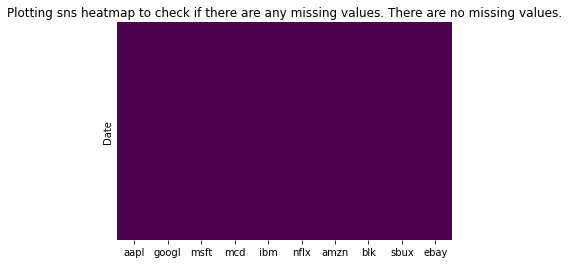

In [10]:
desc_stats1(df_close)

Plotting the returns of the stocks, and we can observe that this specific list of stocks have high positive correlation. (they move in the same direction). This plot is useful in selecting the stocks, because I might want to have stocks that don't have high correlation for diversification of the portfolio. 

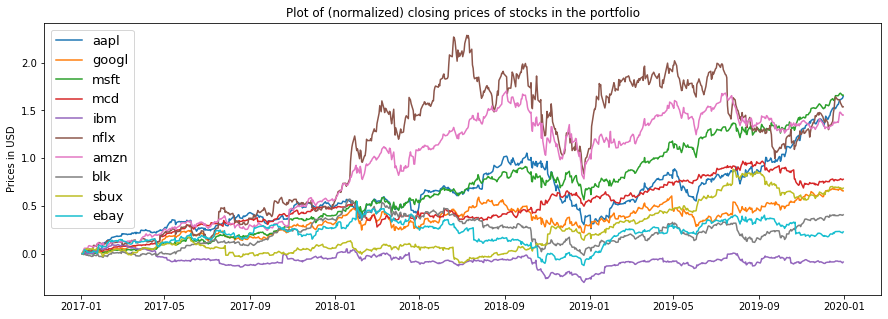

In [11]:
desc_stats2(df_close)

Calculating the correlations, and plotting the heatmap shows us that, indeed majority of the stocks have positive correlation. Because most of them are large cap companies. 

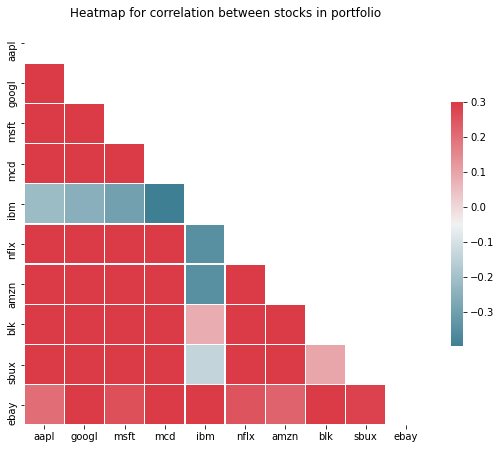

In [12]:
desc_stats3(df_close)

Moving on to the optimization of portfolio allocation:

### functions: p_ret(), p_risk(), sharpe():
#### inputs:
* r: average annual return of the portfolio (calculated as: $ \text{average*business_days}$)
* weight: 10x1 vector of numbers that sum to 1, each representing proportion of portfolio invested in particular stock (if we input more/less than 10 stocks, the weight dimension changes accordingly)
* covmat: covariance matrix of stocks

p_ret calculates the return of portfolio by taking the matrix product of returns and weights r(Nx1)*weight(1xN) = p_ret(1x1), where N is number of columns (stocks)

p_risk calculates the standard deviation of portfolio (risk) as $covmat(N,N)*weight(N,1) = y(1,N)$, $weight(N,1)*y(1,N) = var(1,1)$, $risk = sqrt(var)$

sharpe is sharpe ration defined as return/risk

#### outputs:
these functions are called and used as formulas in the next functions

In [13]:
#Rate of return is each stock's return scaled by it's weight in portfolio
def p_ret(r,weight):
    return r.dot(weight) #matrix product of returns and weights r(10x1)*weight(1x10) = p_ret(1x1)
# Risk level (volatility): srandard deviation of returns
def p_risk(weight,covmat):
    #covmat(10,10)*weight(10,1) = y(1,10)
    #weight(10,1)*y(1,10) = var(1,1)
    #risk = sqrt(var)
    return np.sqrt(np.dot(weight,np.dot(weight,covmat))) 
#Sharpe ratio is risk efficiency; it assesses the return of an investment compared to its risk.
#https://www.investopedia.com/terms/s/sharperatio.asp
def sharpe (p_ret,p_risk):
    return p_ret/risk

### function: efficient_frontier:
#### inputs:
* df_close: dataframe of stocks
* p_change: percent change of the prices
* covmat: covariance matrix of the stocks

$\href{https://www.youtube.com/watch?v=PiXrLGMZr1g}{\text{Markowitz's efficient frontier theory}}$ states that given the historical prices of stocks, we can allocate weights in portfolio so that we can find (1) highest return for a given level of risk, or (2) lowest risk for a given level of return. 
The function below uses constrained optimization to find a vector of weights which give (1) higest return for the standard deviation of our portfolio and (2) lowest risk for the average return of the portfolio. 

#### outputs: 
* w_min: vector of weights (each corresponding to column of df_close) which if applied to the portfolio, results in the smallest standard deviation (risk). 
* w_sharpe: vector of weights which if applied gives highest sharpe ratio. Sharpe ratio is return/risk. 

In [14]:
def efficient_frontier(df_close, p_change, covmat):
    # Setting limits for weights (weight cannot be negative or more than 1)
    # Weights is the share of specific stock in the portfolio
    w_limit = bounds(0, 1)
    # Setting constraint for sum of weights = 1
    constraint = lc(np.ones((p_change.shape[1],), dtype=int),1,1)
    # Want to find minimum risk allocation for a given return
    weight_guess = np.ones(p_change.shape[1]) #placeholder for weights
    x0 = weight_guess/np.sum(weight_guess) #initial value for guessing: vector of equal weights
    
    
    #fun1 calculates volatility
    f1 = lambda w: p_risk(w,covmat)
    #Another function that calculates "1/Sharpe_ratio"
    #I want to find highest possible value for sharpe ratio, so I can minimize the inverse of the function
    f2 = lambda w: p_risk(w,covmat)/p_ret(r,w)

    #CONSTRAINED OPTIMIZATION:
    #minimizing the function "f1" given the constraint above, with a starting value guess x0
    res = minimize(f1,x0,method='trust-constr',constraints = constraint,bounds = w_limit)
    w_min = res.x
    #function returns weights of the stocks that minimizes function 
    res_sharpe = minimize(f2,x0,method='trust-constr',constraints = constraint,bounds = w_limit)
    #This is weights for which we have highest sharpe ratio = return/risk
    w_sharpe = res_sharpe.x
    return w_min, w_sharpe

### function: plot_frontier:
#### inputs:
* p_change: percent change of the prices
* r: average annual return
* covmat: covariance matrix of the stocks
* w_min: vector of weights (each corresponding to column of df_close) which if applied to the portfolio, results in the smallest standard deviation (risk). 
* w_sharpe: vector of weights which if applied gives highest sharpe ratio. Sharpe ratio is return/risk.

Since I have found the return that corresponds to the lowest risk, I can start allowing for trade-offs. I can start increasing risk and re-calculating the weights for optimal sharpe ratio. If we repeat this loop, we will have points, which when we scatter - we get the efficient frontier visualization.

#### output:
plot efficient frontier

In [15]:
def plot_frontier(p_change, r, covmat, w_min, w_sharpe):
    w = w_min
    ports = 100 #allowing for 100 data points in the plot
    w_limit = bounds(0, 1)
    #step vector: ranges from portfolio with highest return, to the return that corresponds to the lowest risk calculated from efficient_frontier
    step = (np.amax(r) - p_ret(r,w_min))/ports
    #array of zeros with shape (100,number of stocks in portfolio)
    #now I will fill this array with vectors of weights
    all_weights = np.zeros((ports, len(p_change.columns)))
    #first and second rows are weights that minimize risk and max returns
    all_weights[0] = w_min
    all_weights[1] = w_sharpe
    
    #also first and second element of return and risk are from function efficient_frontier
    ret_arr = np.zeros(ports)
    ret_arr[0] = p_ret(r,w_min)
    ret_arr[1] = p_ret(r,w_sharpe)
    vol_arr = np.zeros(ports)
    vol_arr[0] = p_risk(w_min,covmat)
    vol_arr[1] = p_risk(w_sharpe,covmat)

    #then i run a loop that works in a same way with efficient_frontier but for each possible return between
    #maximum and minimum, I find the corresponding minimum risk
    for i in range(ports):
        port_ret = p_ret(r,w) + i*step
        constraint1 = lc(np.ones(p_change.shape[1]), 1,1)
        constraint2 = lc(r,port_ret,port_ret)
        #Create x0: initial guesses for weights.
        x0 = w_min
        #Define a function for portfolio volatility.
        fun = lambda w: p_risk(w,covmat)
        a = minimize(fun,x0,method='trust-constr',constraints = [constraint1, constraint2],bounds = w_limit)
        #a.x is the weight at which function is minimized. so I add this to the matrix of weights
        all_weights[i,:]=a.x
        #add return and risk to corresponding vectors
        ret_arr[i]=port_ret
        vol_arr[i]=p_risk(a.x,covmat)

    sharpe_arr = ret_arr/vol_arr  

    plt.figure(figsize=(15,7))
    plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='twilight')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.title('Efficient Frontier Graph')
    plt.show()

### Calling the functions:

In [16]:
pc = df_close.pct_change() #find percent change of prices
p_change=pc.iloc[1:len(pc.index),:] #removing the first row

#Calculate annualized average return for each column (stock). 
r = np.mean(p_change,axis=0)*252 #252 is number is business days
covmat = p_change.cov()

w_min = efficient_frontier(df_close, p_change, covmat)[0]
w_sharpe = efficient_frontier(df_close, p_change, covmat)[1]
r_wmin = p_ret(r,w_min)*100

v_wmin = p_risk(w_min,covmat)
r_wsharpe = p_ret(r,w_sharpe)*100
v_wsharpe = p_risk(w_sharpe,covmat)

### Minimizing risk:
This is the minimum possilbe risk (standard deviation) of this portfolio, and the corresponding return calculations based on the historical data of prices. The vector of weights tell us how much we should allocate to each stock for this result.

In [17]:
print("Minimum possible risk: " + str(round(v_wmin, 4)))
print("Corresponding return: " + str(round(r_wmin, 2)))
print("Weights that minimize risk: " + str(np.around(w_min, 2)))

Minimum possible risk: 0.0082
Corresponding return: 15.56
Weights that minimize risk: [0.03 0.04 0.   0.43 0.18 0.   0.   0.07 0.15 0.09]


### Maximizing returns:
This is the maximum possilbe returns of this portfolio, and the corresponding risk calculations based on the historical data of prices. The vector of weights tell us how much we should allocate to each stock for this result.

In [18]:
print("Maximum possible return: " + str(round(r_wsharpe,2)))
print("Corresponding risk: " + str(round(v_wsharpe,4)))
print("Weights that maximize return: " + str(np.around(w_sharpe, 2)))

Maximum possible return: 28.88
Corresponding risk: 0.0097
Weights that maximize return: [0.22 0.   0.33 0.38 0.   0.01 0.   0.   0.06 0.  ]


### Efficient frontier plot
Here I plot all possible efficient allocations. The points on curve indicate the solutions to constrained optimization problem, where we cannot improve risk or return without sacrificing the other.

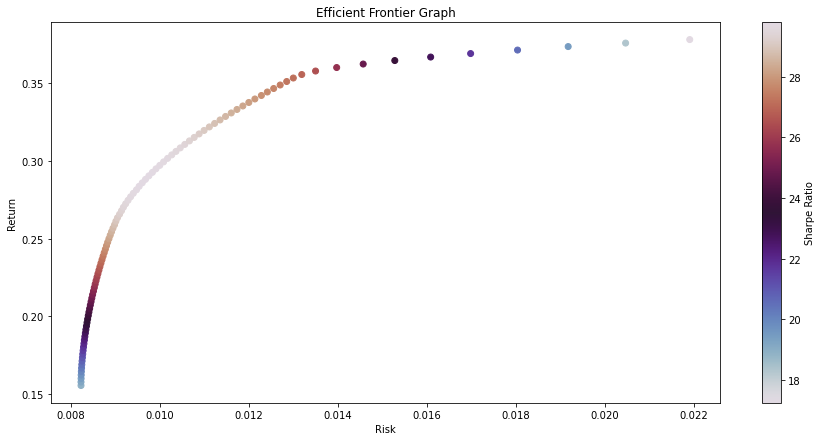

In [19]:
plot_frontier(p_change, r, covmat, w_min, w_sharpe)

# Part 2: single stock price prediction using OLS and SVR

Here I select only one stock, and use 2 regression methods to predict the closing price of the stock using other attributes. I report the RMSE of 2 estimations to choose the more efficient estimator.

### function: create_features:
#### inputs:
* df_stock: dataframe with features(prices: $\href{https://www.investopedia.com/terms/c/closingprice.asp}{\text{closing}}$, $\href{https://www.investopedia.com/terms/o/openingprice.asp}{\text{opening}}$, $\href{https://analyzingalpha.com/open-high-low-close-stocks}{\text{high}}$, low) of one stock as columns

I create 2 additional columns which are:
* daily change: the difference between highest and lowest prices of the day
* day-over-day change: difference of prices between 2 consecutive days

#### output:
updated dataframe with 2 more columns

In [20]:
def create_features(df_stock):
    df_stock['dailychange'] = ((df_stock['High'] - df_stock['Low'] )/ df_stock['Low'])*100
    df_stock['dodchange'] = (abs(df_stock['Adj Close'].shift() - df_stock['Adj Close'] )/ df_stock['Adj Close'])*100
    df_stock = df_stock.iloc[1:len(df_stock.index),:] #removing the first row
    return df_stock

### function: cv()
#### inputs:
* df_stock: updated dataframe from create_features()

Now I want to attempt to predict the closing price of the stock from all other features.
I use scikit learn's cross validation function to split the data into training and test samples randomly. I indicate the test sample size as 20% of the total. Then, I can train regression estimators on training sample, and estimate the out-of-sample prediction quality on test sample. 

#### outputs:
* X_train, X_test: matrixes of explanatory variables
* y_train, y_test: vector of closing prices

In [21]:
def cv(df_stock):
    X = df_stock.drop(['Adj Close'], axis=1)
    y = df_stock['Adj Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    return X_train, X_test, y_train, y_test

### function: estimate_OLS()
#### inputs:
* outputs of cv() function

Fits an OLS regression line on the training sample, and uses the estimators to do prediction on the test sample. RMSE is the square root of average deviation of estimation from the true data (y_test). Higher RMSE indicates poor out-of-sample prediction. 

#### outputs:
* mse_ols: root mean squared error value of OLS estimation

In [22]:
def estimate_OLS(X_train, X_test, y_train, y_test):
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_train = np.reshape(y_train, (-1,1))
    y_test = np.reshape(y_test, (-1,1))
    reg.fit(X_train,y_train) #fit the regression on train sample
    yhat_train = reg.predict(X_train) #preditct yhat for training sample
    yhat = reg.predict(X_test)
    mse_ols = mse(y_test, yhat, squared = False)
    return mse_ols

### function: estimate_SVR()
#### inputs:
* outputs of cv() function

Fits an SVR regression line on the training sample, and uses the estimators to do prediction on the test sample. I chose linear kernel because this option had the best performance. I also report the RMSE.

#### outputs:
* mse_svr: root mean squared error value of SVR estimation

In [23]:
def estimate_SVR(X_train, X_test, y_train, y_test):
    svr = make_pipeline(SVR(kernel="linear"))
    svr.fit(X_train, y_train) #fit the regression on train sample
    yhat = svr.predict(X_test)
    mse_svr = mse(y_test, yhat, squared = False)       
    return mse_svr

In [24]:
def compare_rmse(mse_ols, mse_svr):
    print("RMSE of OLS estimation is: " + str(mse_ols))
    print("RMSE of SVR estimation is: " + str(mse_svr))
    if mse_ols > mse_svr:
        print("SVR is preferred prediction method.")
    else:
        print("OLS is preferred prediction method.")

In [25]:
def get_stocks_help(stocks):
    directory = r'C:\Users\User\Desktop\Fall 2020\scipy\Stocks'
    DF = pd.read_csv(directory + "/" + stocks[0] + ".us.txt", sep = ",", usecols = ['Date'])
    for name in stocks:     
        df = pd.read_csv(directory + "/" + name + ".us.txt", sep = ",", usecols = ['Date','Close'])
        DF = DF.merge(df, how = 'inner', on=['Date', 'Date'], suffixes = ("","_" + str(name)))
        DF = DF.rename(columns={"Close_" + str(name): str(name)})

    DF = DF.rename(columns={"Close": str(stocks[0])})
    close_df = DF.set_index('Date') 
    return close_df

In [26]:
def get_stocks():
    keys = []
    values = []
    name = []
    directory = r'C:\Users\User\Desktop\Fall 2020\scipy\Stocks'
    for filename in os.listdir(directory):
        name = filename.split(".")[0]
        keys.append(name)  
        values.append(name[0])
    stocks = dict(zip(keys, values))
    return stocks

## Results:
For this selection of portfolio, I find that SVR is preferred. I tried few different stock selectioins, and in all cases RMSE of SVR was smaller than OLS.

In [27]:
df_stock = create_features(df_stock)
X_train, X_test, y_train, y_test = cv(df_stock)
mse_ols = estimate_OLS(X_train, X_test, y_train, y_test)
mse_svr = estimate_SVR(X_train, X_test, y_train, y_test)
compare_rmse(mse_ols, mse_svr)

RMSE of OLS estimation is: 0.4300864064143986
RMSE of SVR estimation is: 0.42478259463165513
SVR is preferred prediction method.


## References:
* https://www.investopedia.com/terms/e/efficientfrontier.asp
* https://www.kaggle.com/hershyandrew/markowitz-portfolio-optimization-gold-and-amazon
* https://www.kaggle.com/guybaryosef/portfolio-analysis
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html
* http://www.calculatinginvestor.com/2011/06/07/efficient-frontier-1/